# Foundations of Computational Economics #29

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

## Coding up the Rust model of bus engine replacement

<img src="_static/img/lab.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/QzOVgKIUBqg](https://youtu.be/QzOVgKIUBqg)

Description: Implementation of Rust model in infinite horizon with value function iterations solver

### Bellman equation in expected value function space

$ EV(x,d) $ = the expected value function

$$
\begin{eqnarray}
EV(x,d) &=& \sum_{x' \in X} \log \big( \exp[v(x',0)] + \exp[v(x',1)] \big) \pi(x'|x,d) \\
v(x,d) &=& u(x,d) + \beta EV(x,d)
\end{eqnarray}
$$

- $ x \in \{x_1, \dots x_n \} $, the state space is given by $ n $ grid points of mileage  
- $ d \in \{0,1\} $, the choice space is given by two points  
- $ EV(x,d) $ is $ n $ by $ 2 $ matrix  

#### Instantaneous payoffs

Given by the cost function that depends on the choice

$$
u(x,d,\theta_1)=\left \{
\begin{array}{ll}
    -RC-c(0,\theta_1) & \text{if }d_{t}=\text{replace}=1 \\
    -c(x,\theta_1) & \text{if }d_{t}=\text{keep}=0
\end{array} \right.
$$

- $ RC $ = replacement cost  
- $ c(x,\theta_1) = 0.001 \cdot \theta_1 x $ = cost of maintenance  
- $ \theta_1 $ = preference parameters  

#### Transition matrix for mileage

If not replacing ($ d=0) $

$$
\Pi(d=0)_{n x n} =
\begin{pmatrix}
\theta_{20} & \theta_{21} & \theta_{22} & 0 & \cdot & \cdot & \cdot & 0 \\
0 & \theta_{20} & \theta_{21} & \theta_{22} & 0 & \cdot & \cdot & 0 \\
0 & 0 &\theta_{20} & \theta_{21} & \theta_{22} & 0 & \cdot & 0 \\
\cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
0 & \cdot & \cdot & 0 & \theta_{20} & \theta_{21} & \theta_{22} & 0 \\
0 & \cdot & \cdot & \cdot & 0 & \theta_{20} & \theta_{21} & \theta_{22} \\
0 & \cdot & \cdot & \cdot & \cdot  & 0 & \theta_{20} & 1-\theta_{20} \\
0 & \cdot & \cdot & \cdot & \cdot & \cdot  & 0 & 1
\end{pmatrix}
$$

#### Transition matrix for mileage

If replacing ($ d=1) $

$$
\Pi(d=1)_{n x n} =
\begin{pmatrix}
\theta_{20} & \theta_{21} & \theta_{22} & 0 & \cdot & \cdot & \cdot & 0 \\
\theta_{20} & \theta_{21} & \theta_{22} & 0 & \cdot & \cdot & \cdot & 0 \\
\theta_{20} & \theta_{21} & \theta_{22} & 0 & \cdot & \cdot & \cdot & 0 \\
\cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
\theta_{20} & \theta_{21} & \theta_{22} & 0 & \cdot & \cdot & \cdot & 0 \\
\theta_{20} & \theta_{21} & \theta_{22} & 0 & \cdot & \cdot & \cdot & 0 \\
\theta_{20} & \theta_{21} & \theta_{22} & 0 & \cdot & \cdot & \cdot & 0 \\
\end{pmatrix}
$$

#### Bellman operator and VFI

$$
\begin{eqnarray}
T^*(EV)(x,d) &\equiv& \sum_{x' \in X} \log \big( \exp[v(x',0)] + \exp[v(x',1)] \big) \pi(x'|x,d) \\
v(x,d) &=& u(x,d) + \beta EV(x,d)
\end{eqnarray}
$$

1. Start with arbitrary guess for \$EV(x,d)\$  
1. Apply \$T^*\$ operator  
1. Check for (uniform) convergence  
1. If not converged to a given level of tolerance, return to step 2, otherwise finish.  

#### One more thing

*It is always useful to examine the structure of the problem for insights into better code structure!*

- Bus with just replaced engine is identical to the new bus from the model’s point of view
  $ \Rightarrow EV(x,d = \text{replace}) = EV(0,d = \text{keep}) $ for all $ x $  
- and instead of $ EV(x,d) $ to be $ n $ by $ 2 $ matrix, it is sufficient to work with a vector
  $ EV(x) $ with $ n $ elements  
- we also only need one transition probability matrix then  

- When computing **logsum** functions  


$$
\log \big( \exp[v(x',0)] + \exp[v(x',1)] \big)
$$

- we can avoid computing exponential of large numbers by using the equivalent  


$$
M + \log \big( \exp[v(x',0)-M] + \exp[v(x',1)-M] \big)
$$

Rust model at id=140320486659664


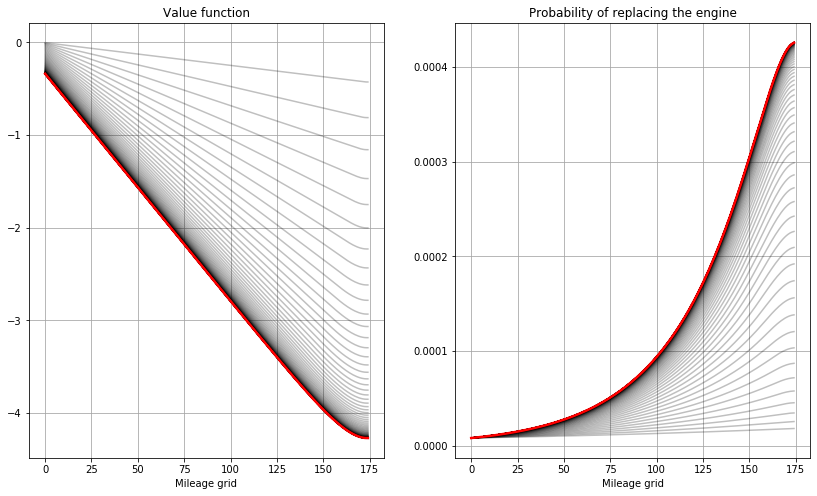

Solution ev=
[-0.33831227 -0.36286609 -0.38741983 -0.4119735  -0.43652708 -0.46108058
 -0.48563399 -0.51018731 -0.53474054 -0.55929368 -0.58384672 -0.60839965
 -0.63295248 -0.65750521 -0.68205782 -0.70661032 -0.73116271 -0.75571497
 -0.78026711 -0.80481912 -0.829371   -0.85392275 -0.87847435 -0.90302581
 -0.92757711 -0.95212827 -0.97667926 -1.00123009 -1.02578075 -1.05033124
 -1.07488154 -1.09943165 -1.12398157 -1.14853129 -1.1730808  -1.19763009
 -1.22217915 -1.24672799 -1.27127658 -1.29582492 -1.32037301 -1.34492082
 -1.36946835 -1.39401558 -1.41856251 -1.44310913 -1.46765541 -1.49220135
 -1.51674693 -1.54129213 -1.56583694 -1.59038134 -1.61492531 -1.63946883
 -1.66401189 -1.68855444 -1.71309649 -1.73763799 -1.76217892 -1.78671925
 -1.81125896 -1.835798   -1.86033635 -1.88487396 -1.9094108  -1.93394683
 -1.958482   -1.98301625 -2.00754955 -2.03208184 -2.05661305 -2.08114312
 -2.10567199 -2.13019959 -2.15472583 -2.17925063 -2.20377391 -2.22829557
 -2.25281551 -2.27733362 -2.30184978 -

In [1]:
# THIS IS DEVELOPPED IN THE VIDEO

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class zurcher():
    '''Harold Zurcher bus engine replacement model class, VFI version'''

    def __init__(self,
                 n = 175,           # number of state points
                 RC = 11.7257,      # replacement cost
                 c = 2.45569,       # parameter of maintance cost (theta_1)
                 p = [0.0937,0.4475,0.4459,0.0127],  # probabilities of transitions (theta_2)
                 beta = 0.9999):    # discount factor
        '''Init for the Zurcher model object'''
        assert sum(p)<=1.0, 'Transition probability parameters must sum up to <1'
        self.RC, self.c, self.p, self.beta, self.n= RC, c, p, beta, n

    @property
    def n(self):
        '''Attrinute getter for n'''
        return self.__n

    @n.setter
    def n(self, value):
        '''Attribute n setter'''
        self.__n = value
        self.grid = np.arange(self.__n)
        self.trpr = self.__transition_probs()

    def __repr__(self):
        '''String representation of the Zurcher model'''
        return 'Rust model at id={}'.format(id(self))

    def __transition_probs(self):
        '''Computing the transision probability matrix'''
        trpr = np.zeros((self.__n,self.__n))  # init
        probs = self.p + [1-sum(self.p)]  # ensure sum up to 1
        for i,p in enumerate(probs):
            trpr += np.diag([p]*(self.__n-i),k=i)
        trpr[:,-1] = 1.-np.sum(trpr[:,:-1],axis=1)
        return trpr

    def bellman(self,ev0):
        '''Bellman operator for the model'''
        x = self.grid  # points in the next period state
        mcost = -0.001*x*self.c
        vx0 = mcost + self.beta * ev0  # vector of v(x,0)
        vx1 = -self.RC + mcost[0] + self.beta * ev0[0]  # vector of v(x,1)
        M = np.maximum(vx0,vx1)
        logsum = M + np.log(np.exp(vx0-M) + np.exp(vx1-M))
        ev1 = self.trpr @ logsum[:,np.newaxis]
        ev1 = ev1.ravel()
        # recompute v(x,d) for current period choice probabilities
        vx0 = mcost + self.beta * ev1  # vector of v(x,0)
        vx1 = -self.RC + mcost[0] + self.beta * ev1[0]  # vector of v(x,1)
        pr1 = 1 / (np.exp(vx0-vx1)+1)  # choice prob to repace
        return ev1, pr1

    def solve_vfi(self,tol=1e-6,maxiter=100,callback=None):
        '''Solves the Rust model using value function iterations
        '''
        ev0 = np.zeros(self.n) # initial point for VFI
        for i in range(maxiter):  # main loop
            ev1, pr1 = self.bellman(ev0)  # update approximation
            err = np.amax(np.abs(ev0-ev1))
            if callback != None: callback(iter=i,err=err,ev1=ev1,ev0=ev0,pr1=pr1,model=self)
            if err<tol:
                break  # break out if converged
            ev0 = ev1  # get ready to the next iteration
        else:
            raise RuntimeError('Failed to converge in %d iterations'%maxiter)
        return ev1, pr1

    def solve_show(self,maxiter=1000,tol=1e-6,**kvargs):
        '''Illustrate solution'''
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
        ax1.grid(b=True, which='both', color='0.65', linestyle='-')
        ax2.grid(b=True, which='both', color='0.65', linestyle='-')
        ax1.set_xlabel('Mileage grid')
        ax2.set_xlabel('Mileage grid')
        ax1.set_title('Value function')
        ax2.set_title('Probability of replacing the engine')
        def callback(**argvars):
            mod, ev, pk = argvars['model'],argvars['ev1'],argvars['pr1']
            ax1.plot(mod.grid,ev,color='k',alpha=0.25)
            ax2.plot(mod.grid,pk,color='k',alpha=0.25)
        ev,pk = self.solve_vfi(maxiter=maxiter,tol=tol,callback=callback,**kvargs)
        # add solutions
        ax1.plot(self.grid,ev,color='r',linewidth=2.5)
        ax2.plot(self.grid,pk,color='r',linewidth=2.5)
        plt.show()
        return ev,pk


model = zurcher(n = 15,p=[0.2,0.2,0.4], beta=0.5)
model = zurcher(beta=0.9)
print(model)
ev,pr = model.solve_show()
print('Solution ev=')
print(ev)
print('Solution pr=')
print(pr)

In [2]:
# THIS IS AN EARLIER VERSION OF THE CODE
# (there is bug here..)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class zurcher():
    '''Harold Zurcher bus engine replacement model class, VFI version'''

    def __init__(self,
                 n = 175,           # number of state points
                 RC = 11.7257,      # replacement cost
                 c = 2.45569,       # parameter of maintance cost (theta_1)
                 p = [0.0937,0.4475,0.4459,0.0127],  # probabilities of transisions (theta_2)
                 beta = 0.9999):    # discount factor
        '''Initializator for the zurcher class'''
        assert sum(p)<=1.0,'sum of transision probability parameters must not exceed unity'
        self.p = p        # parameters for transision probabilities
        self.n = n        # set number of grid points on the state space
        self.RC = RC      # replacement cost
        self.c = c        # cost function parameter
        self.beta = beta  # discount factor

    @property
    def n(self):
        '''Dimension getter'''
        return self.__n # internal dimension variable

    @n.setter
    def n(self,n):
        '''Dimension setter, updaing the grid and transision probabilities'''
        self.__n = n
        # create grid for the set dimension
        self.grid = np.arange(n) # 0,..,n-1 index of grid points
        # create transition prob for the set dimension
        p = self.p # "copy" the list of parameters
        p.append(1.0-sum(p)) # add the last element to ensure 1.0 in sum
        self.P1,self.P2 = self.transition_probability(np.array(p)) # compute transision probabilities

    def __repr__(self):
        '''String representation of the Zurcher model object'''
        # id() is unique identifier for the variable (reference), convert to hex
        return 'Zurcher bus engine replacement model with id=%s' % hex(id(self))

    def transition_probability(self,p):
        '''Compute transition probability matrixes conditional on choice'''
        # conditional on d=0, no replacement
        P1 = np.full((self.n,self.n),0.0)
        for i in range(self.n):
            if i <= self.n-p.size:
                # lines where p vector fits entirely
                P1[i][i:i+p.size]=p
            else:
                P1[i][i:] = p[:self.n-p.size-i]
                P1[i][-1] = 1.0-P1[i][:-1].sum()
        # conditional on d=1, replacement
        P2 = np.full((self.n,self.n),0.0)
        for i in range(self.n):
            P2[i][:p.size]=p
        return P1,P2

    def bellman(self,ev0,output=0):
        ''' Bellman operator for the model
            Input: current approximation of the EV as column vector
                   output = type of output requested
            Output: new approximation of EV
                    d=0 choice probability (if output>0)
                    Frechet derivative of Bellman operator (if output>1)
        '''
        # EV0 is current approximation of EV on the fixed grid
        # For d=0 it holds values for all mileages
        # For d=1 (replacement) we use the first value EV0[0]
        # So, instead of EV(x,d) for d=0,1, we can use only one vector!
        assert np.all(ev0.shape==(self.n,1)),'Expecting EV as column vector'
        x = self.grid.reshape((self.n,1)) # states (in the next period), column vector
        c = 0.001*self.c*x # maintenance cost in all states
        v0 = -c + self.beta*ev0 # value of not replacing
        v1 = -c[0] -self.RC + self.beta*ev0[0] # value of replacing
        # recenter the values for numerical stability of logsum !!!!!!!!!!!!!!!!
        maxv = np.maximum(v0,v1)
        logsum = maxv + np.log(np.exp(v0-maxv) + np.exp(v1-maxv))
        ev1 = self.P1 @ logsum # matrix multiplication, result as column vector
        if output == 0:
            return ev1
        # keep (no replacement) choice probability
        pk = 1/(1+np.exp(v1-v0))
        if output == 1:
            return ev1,pk

    def solve_vfi(self, maxiter=1000, tol=1e-6, callback=None):
        '''Solves the model using successive approximations (VFI)'''
        ev0 = np.full((self.n,1),0) # initial guess of EV
        for iter in range(maxiter):
            ev1,pk = self.bellman(ev0,output=1)
            stp = np.max(abs(ev1-ev0))
            if callback:
                if iter==0: stp0=1.0
                callback(iter,self,ev1,pk,stp,stp/stp0) # callback for making plots
            if stp < tol:
                break
            ev0=ev1
            stp0=stp
        else:  # when i went up to maxiter
            print('No convergence: maximum number of iterations achieved!')
        return ev1,pk

    def solve_show(self,solver='vfi',maxiter=1000,tol=1e-6,**kvargs):
        '''Illustrate solution'''
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
        ax1.grid(b=True, which='both', color='0.65', linestyle='-')
        ax2.grid(b=True, which='both', color='0.65', linestyle='-')
        ax1.set_xlabel('Mileage grid')
        ax2.set_xlabel('Mileage grid')
        ax1.set_title('Value function')
        ax2.set_title('Probability of keeping the engine')
        def callback(iter,mod,ev,pk,stp,dstp):
            if iter==0:
                print('%4s %16s %16s'%('iter','err','err(i)/err(i-1)'))
                print('-'*40)
            print('%4d %16.12f %16.12f'%(iter,stp,dstp))
            ax1.plot(mod.grid,ev,color='k',alpha=0.25)
            ax2.plot(mod.grid,pk,color='k',alpha=0.25)
        if solver=='vfi':
            ev,pk = self.solve_vfi(maxiter=maxiter,tol=tol,callback=callback,**kvargs)
        elif solver=='nk':
            ev,pk = self.solve_nk(maxiter=maxiter,tol=tol,callback=callback,**kvargs)
        elif solver=='poly':
            ev,pk = self.solve_poly(maxiter=maxiter,tol=tol,callback=callback,**kvargs)
        else:
            print('Unknown solver')
            return None
        # add solutions
        ax1.plot(self.grid,ev,color='r',linewidth=2.5)
        ax2.plot(self.grid,pk,color='r',linewidth=2.5)
        plt.show()
        return ev,pk

In [3]:
# investigate how parts of the code work:
model = zurcher(RC=.5,n=12,p=[0.65,0.2,0.1]) # model instance
print('Model grid:\n',model.grid)
print(model) # string representation
print('Transition probabilities conditional on not replacing:\n',model.P1)
print('Transition probabilities conditional on replacing:\n',model.P2)
ev,pk = model.bellman(np.full((model.n,1),0),output=1)
print('Bellman one run:\n',ev)
print('Probability of keeping:\n',pk)

Model grid:
 [ 0  1  2  3  4  5  6  7  8  9 10 11]
Zurcher bus engine replacement model with id=0x7f9eb83bda90
Transition probabilities conditional on not replacing:
 [[0.65 0.2  0.1  0.05 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.65 0.2  0.1  0.05 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.65 0.2  0.1  0.05 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.65 0.2  0.1  0.05 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.65 0.2  0.1  0.05 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.65 0.2  0.1  0.05 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.65 0.2  0.1  0.05 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.65 0.2  0.1  0.05 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.65 0.2  0.1  0.05]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.65 0.2  0.15]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.65 0.35]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]
Transition probabilities conditional on replacing:
 [[0.65 0.2  0.1  0.05 0.

iter              err  err(i)/err(i-1)
----------------------------------------
   0   0.417013120838   0.417013120838
   1   0.370621231082   0.888751966213
   2   0.327694171617   0.884175390224
   3   0.287961455490   0.878750616984
   4   0.251303448761   0.872698216966
   5   0.217734713293   0.866421509000
   6   0.187291798495   0.860183457487
   7   0.160016330707   0.854369128773
   8   0.135901357738   0.849296800756
   9   0.114862847118   0.845192785634
  10   0.096741182600   0.842232149276
  11   0.081326735019   0.840663023065
  12   0.068378239873   0.840784274152
  13   0.057792280046   0.845185254165
  14   0.049175736163   0.850904932690
  15   0.042089382417   0.855897353068
  16   0.036210267283   0.860318332170
  17   0.031292801483   0.864196920689
  18   0.027151337854   0.867654430650
  19   0.023641549056   0.870732380965
  20   0.020650667367   0.873490451829
  21   0.018089047165   0.875954604423
  22   0.015885781951   0.878198934777
  23   0.013982833446  

  51   0.000599439885   0.899050216880
  52   0.000538991569   0.899158669047
  53   0.000484708110   0.899286998748
  54   0.000435937364   0.899381204954
  55   0.000392112077   0.899468843198
  56   0.000352728537   0.899560502761
  57   0.000317316129   0.899604358475
  58   0.000285490244   0.899702906408
  59   0.000256863810   0.899728853221
  60   0.000231122587   0.899786493992
  61   0.000207970483   0.899827604103
  62   0.000187139721   0.899837888320
  63   0.000168407479   0.899902375562
  64   0.000151550220   0.899901957177
  65   0.000136383280   0.899921362375
  66   0.000122738027   0.899949221210
  67   0.000110456674   0.899938484602
  68   0.000099407298   0.899966423032


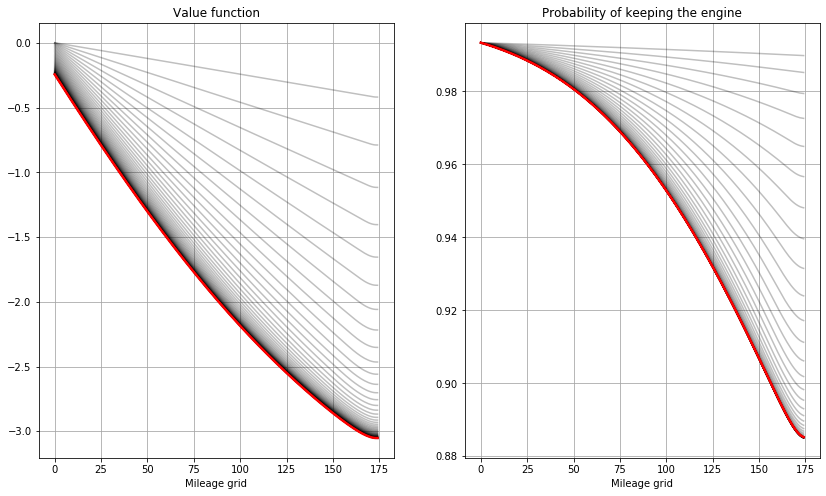

In [4]:
# solve Harold Zurcher model for different parameters
m = zurcher(beta=0.9,RC=5.0)
ev,pk = m.solve_show(maxiter=500,tol=1e-4)

### Further learning resources

- Matlab implementation of full solver and Rust estimator (NFXP) [https://github.com/dseconf/DSE2019/tree/master/02_DDC_SchjerningIskhakov](https://github.com/dseconf/DSE2019/tree/master/02_DDC_SchjerningIskhakov)  